**가계 대출 시계열 분석 프로젝트**
<br>본 프로젝트의 목적은 SARIMAX기법을 활용하여 가계 대출의 추이와 시계열 추이를 파악하는 것이다. 
단순회귀분석으로도 충분해 보이는 시계열 데이터를 선택함으로써 시계열과 회귀분석의 성능 차이를 비교하는 것도 side 목표 중에 하나이다. 

In [2]:
# 필요한 패키지 정의 
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import datetime 

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from sklearn import linear_model

import seaborn as sns
import os 

plt.style.use("default")
plt.style.use("seaborn-whitegrid")
#sns.set(style='ticks', context='poster')


In [3]:
# 필요한 데이터 엑셀 형태로 정리 

os.listdir()
#pd.set_option('display.float_format', lambda x: '%.5f' % x)

[' 전세가격.xlsx',
 "Households Debt in Korea('08~).xlsx",
 'Script.ipynb',
 'tests for time series.xlsx',
 '.ipynb_checkpoints']

# 데이터 불러들이기 / TEST, TRAIN 분할 / 회귀 모형 설계 

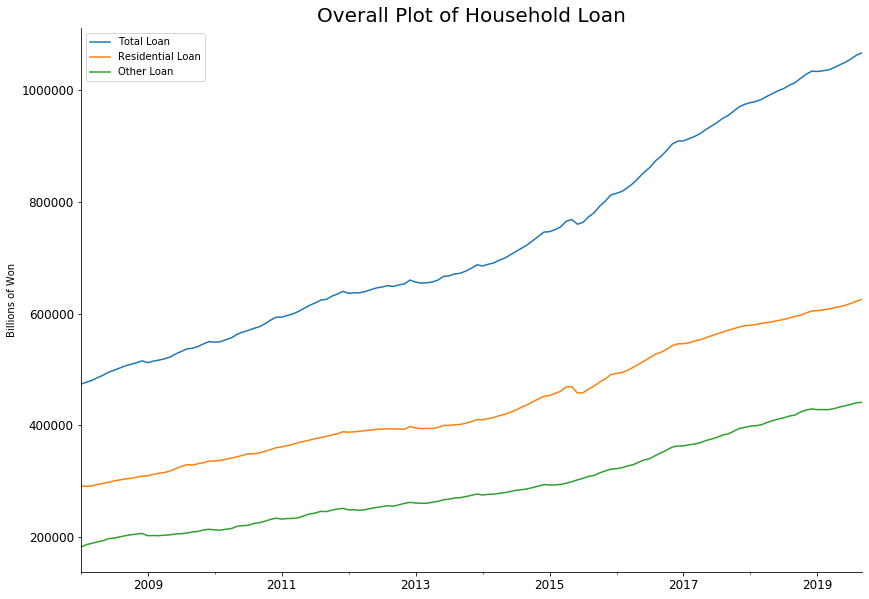

In [176]:
data = pd.read_excel("Households Debt in Korea('08~).xlsx", skiprows = 1, header = 1);
data.head()
data.drop("#", axis = 1, inplace = True)

columns = data.columns
val = ["Date", "Total Loan", "Residential Loan", "Other Loan"]
dic = dict(zip(columns, val))

data.rename(dic, inplace = True, axis = 1)
data.set_index("Date", inplace = True)

data.index = pd.to_datetime(data.index)

data["Year"] = data.index.strftime("%Y").astype(int)
data["Month"] = data.index.strftime("%b")

train = data[data.Year != 2019]
test = data[data.Year == 2019]
#print("-- TRAIN -- ")
#display(train)
#print("-- TEST -- ")
#test
pd.DataFrame(data["Total Loan"].describe(include = "all"))


data.iloc[:, 0:3].plot(figsize = (14,10))
plt.xlabel("")
plt.title("Overall Plot of Household Loan", fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel("Billions of Won")
sns.despine()

## 차분 함수 정의 (DIFFERENCING)

In [48]:
log_train = np.log(train["Total Loan"])
log_diff = log_train.diff().dropna()


def differencing(dataset, interval=1):
    new_dataset = dataset.copy(deep = True)
    for i in range(interval, len(dataset)):
        new_dataset[i] = dataset[i] - dataset[i - interval]
    return new_dataset.iloc[interval:]

log_yearly_train = differencing(log_train, 12)
log_yearly_train_dif = differencing(log_yearly_train,1)


# invert differenced value
#def inverse_difference(history, yhat, interval=1):
#	return yhat + history[-interval]

log_yearly_test = differencing(np.log(data["Total Loan"]), interval = 12)
log_yearly_test

Date
2009-01-01    0.077944
2009-02-01    0.076410
2009-03-01    0.072669
2009-04-01    0.066882
2009-05-01    0.064453
                ...   
2019-05-01    0.050257
2019-06-01    0.049668
2019-07-01    0.051216
2019-08-01    0.051886
2019-09-01    0.051314
Name: Total Loan, Length: 129, dtype: float64

## 추후에 비교할 회귀 분석 모형 설정 

In [361]:
reg_train = train[["Total Loan", "Month"]]


reg_month = pd.get_dummies(reg_train["Month"]).iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11]]
                           
reg_train = pd.concat([reg_train["Total Loan"],reg_month], axis = 1)

reg_train["Time"] = range(1,len(reg_train)+1)


#X  = reg_train.iloc[:,2:]
X = reg_train["Time"]
#X = reg_train.loc[:, ["Time", "Jan"]]

Y = reg_train["Total Loan"]


def regression(X, Y, pred = False, display = True): 
        X = sm.add_constant(X)
        model = sm.OLS(Y,X).fit()
        
        if display:
            print(model.summary())
        
        if pred:
            return model.predict(X)

#print('Parameters: ', results.params)
#print('R2: ', results.rsquared)

#reg_X1 = train[["Total Loan", "Month"]]
#reg_X1 = pd.get_dummies(reg_X1["Month"].loc[:,"Jan"]]

#regression(X, Y, pred = False)

linear_pred = regression(X, Y, True, False)
linear_pred

#new_X = pd.Series(range(1,len(data)+1))

#new_X.index = data.index
#new_X = sm.add_constant(new_X)

X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()
linear_predictions = model.predict(X)

new_X

model.summary()

/Users/macintosh/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Total Loan   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     3244.
Date:                Tue, 17 Dec 2019   Prob (F-statistic):           8.54e-94
Time:                        20:58:25   Log-Likelihood:                -1554.1
No. Observations:                 132   AIC:                             3112.
Df Residuals:                     130   BIC:                             3118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.36e+05   5539.468     78.699      0.000    4.25e+05    4.47e+05
Time        4116.4128     72.276     56.954      0.000    3973.423    4259.402
==============================================================================
Omnibus:                       50.955   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.936
Skew:                          -0.220   Prob(JB):                       0.0115
Kurtosis:                       1.803   Cond. No.                         154.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [182]:
reg_train

,Total Loan,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Time
Date,,,,,,,,,,,,,,
2008-01-01,473606.9,0,0,0,0,1,0,0,0,0,0,0,0,1
2008-02-01,476919.4,0,0,0,1,0,0,0,0,0,0,0,0,2
2008-03-01,480414.7,0,0,0,0,0,0,0,1,0,0,0,0,3
2008-04-01,485302.9,1,0,0,0,0,0,0,0,0,0,0,0,4
2008-05-01,489620.6,0,0,0,0,0,0,0,0,1,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,1008702.8,0,1,0,0,0,0,0,0,0,0,0,0,128
2018-09-01,1013127.3,0,0,0,0,0,0,0,0,0,0,0,1,129
2018-10-01,1021081.8,0,0,0,0,0,0,0,0,0,0,1,0,130


## 회귀식과 실제 y값 비교 

/Users/macintosh/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


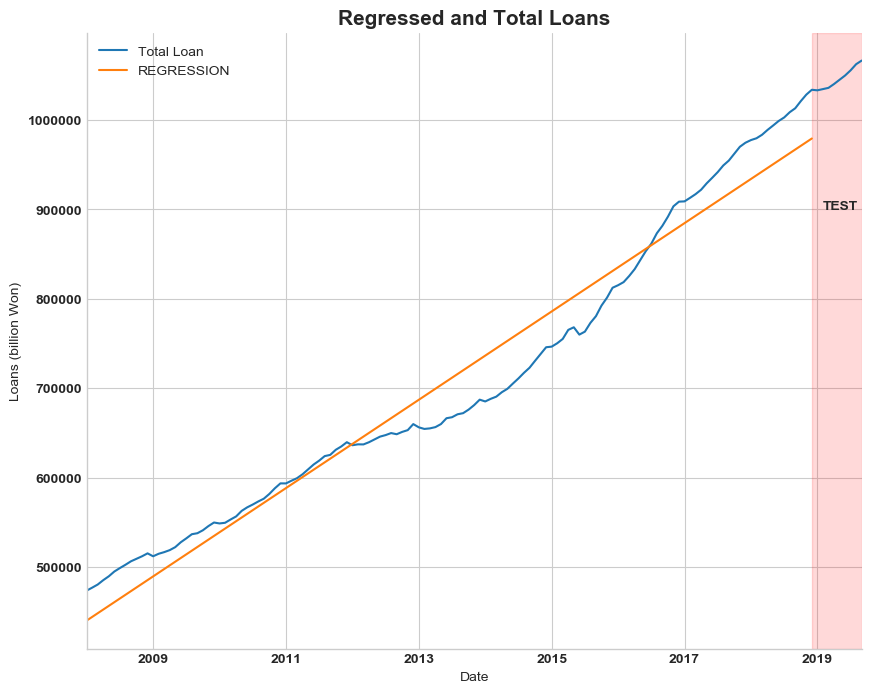

In [6]:
total_loan = data[["Total Loan", "Year", "Month"]]

plt.style.use("default")
plt.style.use("seaborn-whitegrid")

data.loc[:, "Total Loan"].plot(figsize = (10,8));
plt.title("Regressed and Total Loans", fontweight = "bold", fontsize = 15)
plt.xlabel("")
plt.ylabel("Loans (billion Won)")
plt.xticks(fontweight = "bold")
plt.yticks(fontweight = "bold")
plt.legend(fontsize = 15);

plt.axvspan("2018-12-01","2019-09-01" ,alpha=0.15, color='red')
plt.text("2019-02-01", 900000, "TEST", fontweight = "bold");

pred = regression(X, Y, pred = True, display = False)
pred.plot(label = "REGRESSION", legend = True)


sns.despine()


In [7]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(1,3, figsize = (16,10))
for i in range(3):
    ax[i].plot(data[val[i+1]])
    ax[i].set_xticklabels(data.index, rotation = 30)
    ax[i].xaxis.set_major_formatter(DateFormatter("%Y"))
    ax[i].set_title(str(val[i+1]))
    if (i == 1 or 2):
    sns.despine()
                    
plt.tight_layout()

    
#ax.plot(data["Total Loan"])



IndentationError: expected an indented block (<ipython-input-7-d0f394d1758d>, line 10)

# 시계열 분석 

## 추세, 히스토그램, ACF, PACF를 보여주는 tsplot 정의

In [55]:
def tsplot1(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, color = "red")
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x1c2ac4e9b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2c8806a0>)

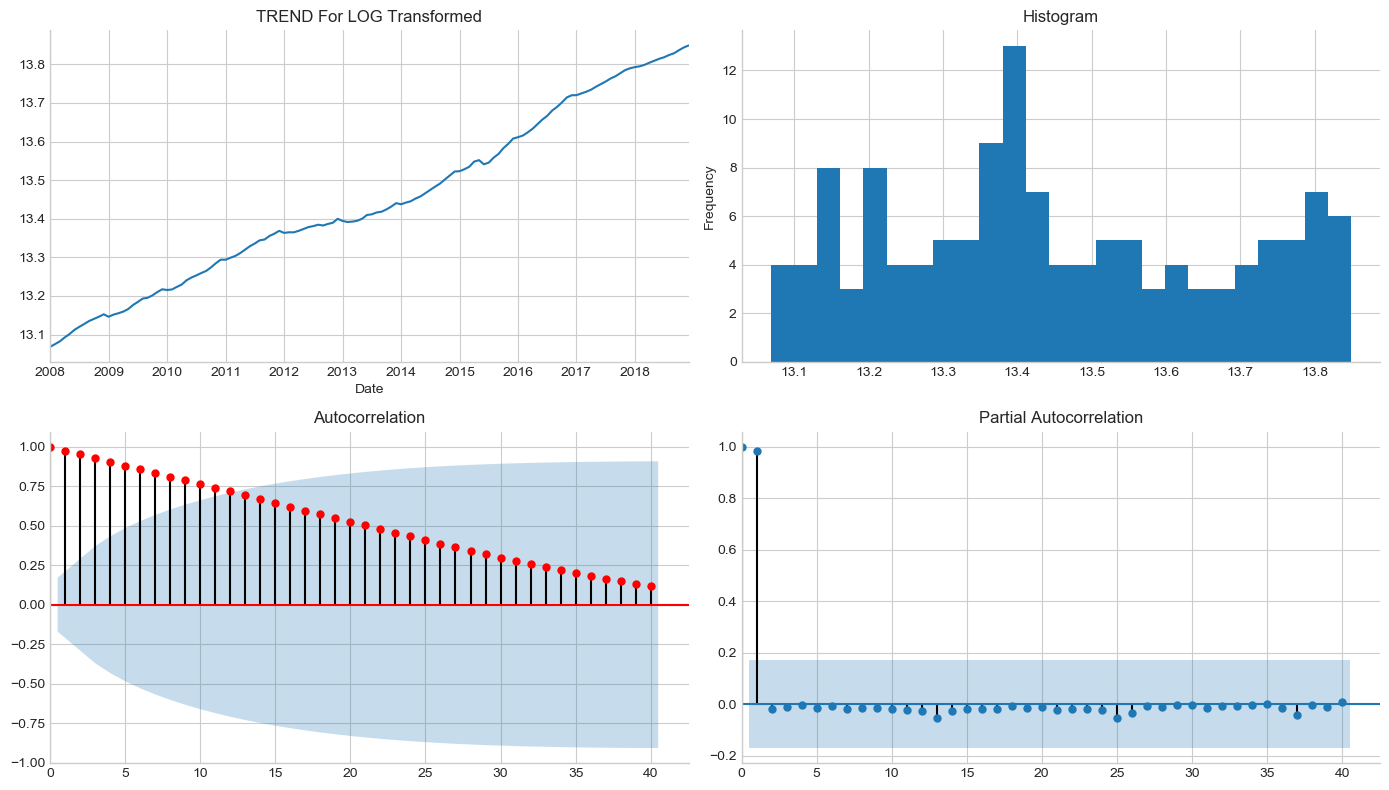

In [56]:
tsplot1(log_train, lags = 40, title = "TREND For LOG Transformed")

## 추세, 박스플랏, ACF, PACF 보여주는 tsplot2 정의

In [5]:
def tsplot2(y, lags=40, title='', figsize=(14, 6)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    box_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y["Total Loan"].plot(ax=ts_ax)
    ts_ax.set_title(title)
    ts_ax.set_xlabel("")
    sns.boxplot(x="Month",y="Total Loan", data=y[y.Year != 2019], ax = box_ax)
    box_ax.set_title('Box Plot by Months')
    box_ax.set_xlabel("")
    box_ax.set_ylabel("")
    smt.graphics.plot_acf(y["Total Loan"], lags=lags, ax=acf_ax, zero = False)
    smt.graphics.plot_pacf(y["Total Loan"], lags=lags, ax=pacf_ax, zero = False)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

total_loan = data[["Total Loan", "Year", "Month"]]

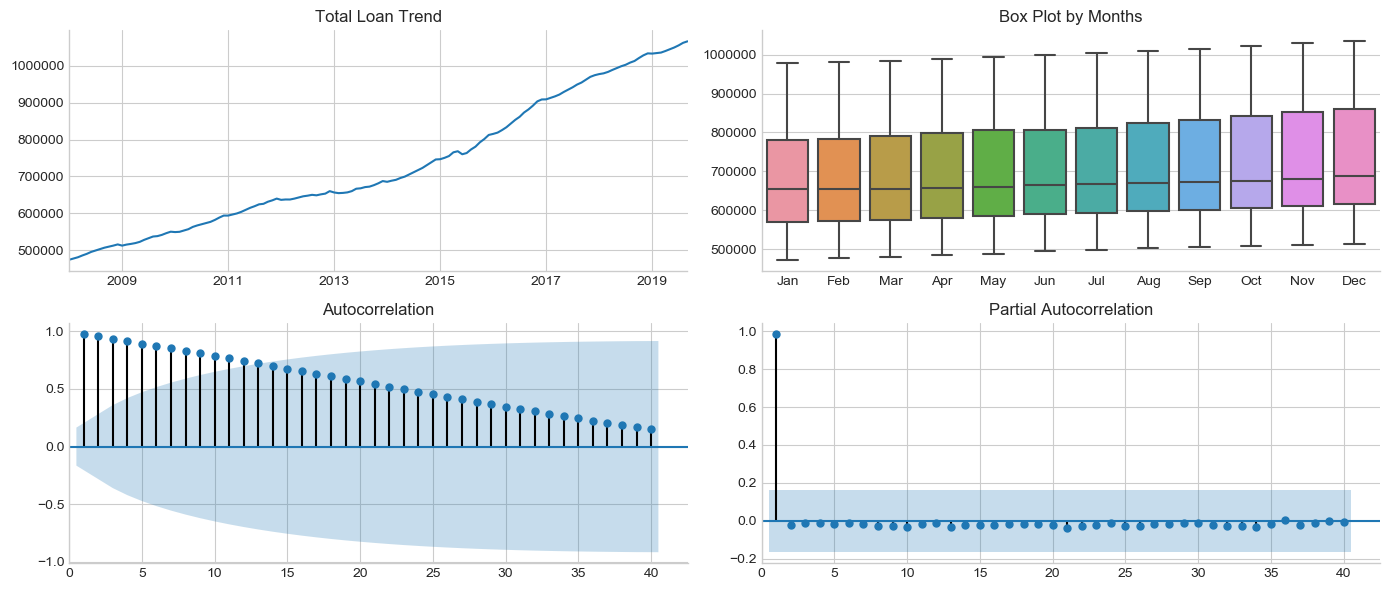

In [6]:
tsplot(total_loan, title= "Total Loan Trend");

## ARIMA(p,q,r)의 p, r 식별을 위한 ACF, PACF 분석

In [92]:
def acf_pacf(dataset): 
    fig, ax = plt.subplots(2,1,figsize = (6,7), sharey = True)
    sm.graphics.tsa.plot_acf(dataset, ax = ax[0], color = "red", lags = 40)
    sm.graphics.tsa.plot_pacf(dataset, ax = ax[1], lags = 40)
    for ax in ax: 
        ax.set_ylim((-0.4, 1))
    plt.tight_layout()

  

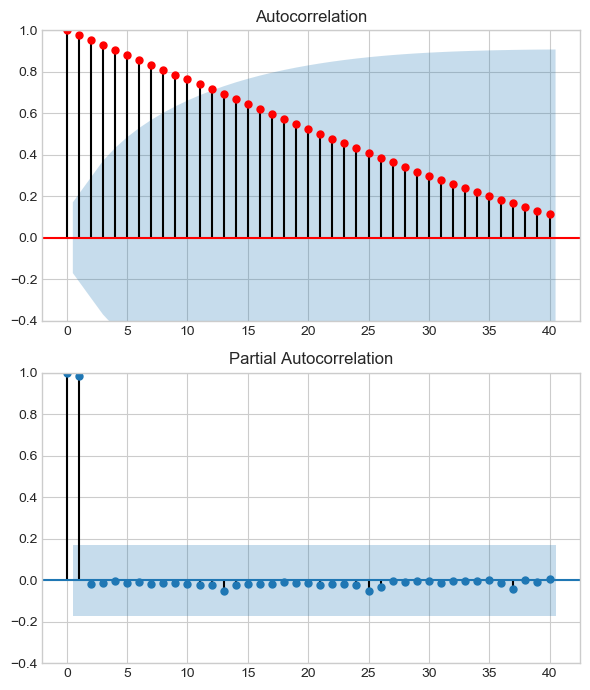

In [95]:
acf_pacf(log_train)
#acf_pacf(log_train.diff().dropna())

## 정상성 검정을 위한 AUGMENTED DICKEY FULLER TEST 정의

In [200]:
from statsmodels.tsa.stattools import adfuller

adfuller1 = adfuller(log_train)

# maxlags 는 12로 설정하였다. 
def a_dickeyfuller(dataset, maxlags = 12): 
    reg = ["c", "ct", "nc"]
    maxlag = range(1,maxlags+1)
    constant = pd.DataFrame({"Lags":maxlag, 
                             "ADF Statistic":maxlag,
                             "P-Value":maxlag,
                             "# Observations":maxlag,
                             "Critical (1%)":maxlag, 
                             "Critical (5%)":maxlag,
                             "Result": maxlag}, index = maxlag)
    
    constant_trend = pd.DataFrame({"Lags":maxlag, 
                                   "ADF Statistic":maxlag,
                                   "P-Value":maxlag,
                                   "# Observations":maxlag,
                                   "Critical (1%)":maxlag, 
                                   "Critical (5%)":maxlag, 
                                   "Result": maxlag}, index = maxlag)
      
    no_constant = pd.DataFrame({"Lags":maxlag, 
                                "ADF Statistic":maxlag,
                                "P-Value":maxlag,
                                "# Observations":maxlag,
                                "Critical (1%)":maxlag, 
                                "Critical (5%)":maxlag,
                                "Result": maxlag}, index = maxlag)
    
    tables = [constant, constant_trend, no_constant]
    
    
    # 함수 내에 가설 검정을 하도록 포함시켰다.  
    for i in range(3):
        for j in maxlag:
            result = adfuller(dataset, regression = reg[i], autolag='AIC', maxlag = j)
            tables[i].loc[j,"Lags"] = j
            tables[i].loc[j,"ADF Statistic"] = result[0]
            tables[i].loc[j,"P-Value"] = result[1]
            tables[i].loc[j,"# Observations"] = result[3]
            tables[i].loc[j,"Critical (1%)"] = result[4]["1%"]
            tables[i].loc[j,"Critical (5%)"] = result[4]["5%"]
            if (tables[i].loc[j,"P-Value"] > 0.05):
                tables[i].loc[j, "Result"] = "Not REJECT = Not Stationary"
            else:
                tables[i].loc[j, "Result"] = "REJECT = Stationary"
       
    return tables # 테이블의 형태로 반환




In [5]:
#c, ct, nt = a_dickeyfuller(log_yearly_train.diff().dropna(), 12)

adfuller(log_yearly_train.diff().dropna())


## LOG변환 및 LOG미변환 데이터를 PACF를 통해 비교 

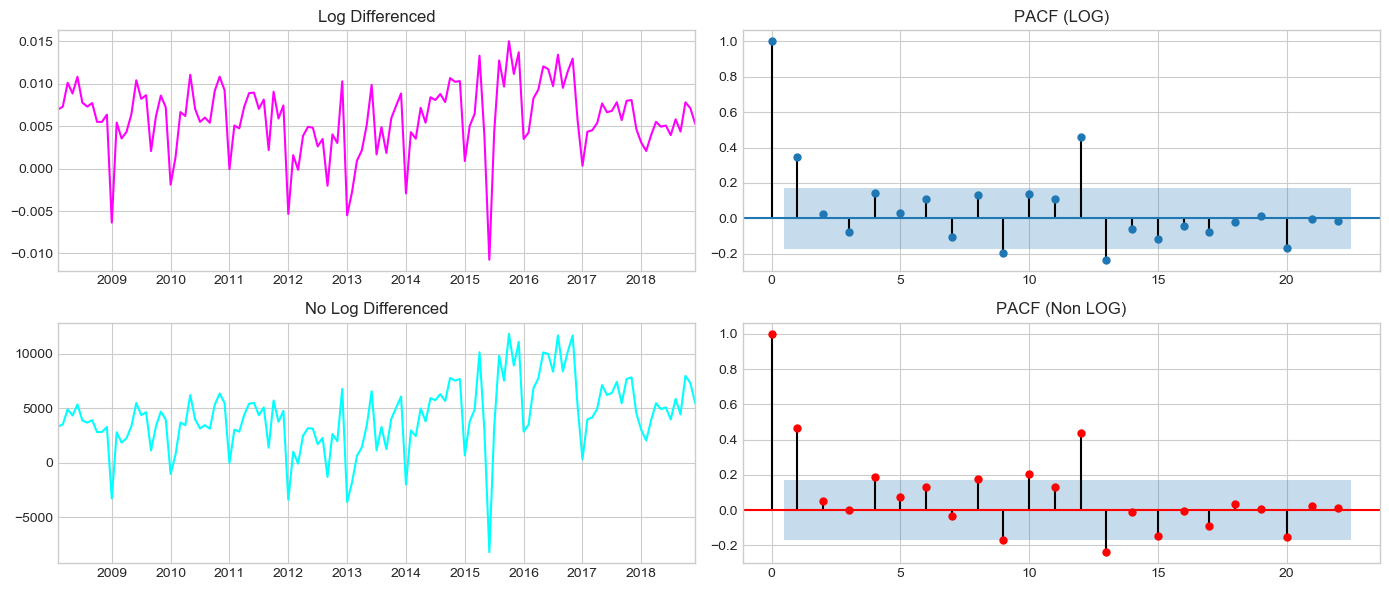

In [543]:
diff = train["Total Loan"].diff().dropna()

fig = plt.figure(figsize=(14,6))
layout = (2, 2)
graph  = plt.subplot2grid(layout, (0, 0))
pacf = plt.subplot2grid(layout, (0, 1))
graph2  = plt.subplot2grid(layout, (1, 0))
pacf2 = plt.subplot2grid(layout, (1, 1))

log_diff.plot(ax = graph, c = "magenta")
graph.set_xlabel("")
graph.set_title("Log Differenced")
sm.graphics.tsa.plot_pacf(log_diff, ax = pacf, title = "PACF (LOG)")
diff.plot(ax = graph2, c = "aqua")
graph2.set_xlabel("")
graph2.set_title("No Log Differenced")
sm.graphics.tsa.plot_pacf(diff, ax = pacf2, c = "red", title = "PACF (Non LOG)");

plt.tight_layout()


## 대출 구조 

- 거의 모든 대출은 년 단위로 이루어진다. 그렇기에 위에서는 볼 수 없었던, yearly_seasonality 가 존재한다는 것을 알 수 있다. 
- 이에 따라, 기존의 train data의 yearly seasonality를 제거하고 이에 log를 씌운 값으로 모델링을 진행하였다. 

## SARIMAX 모델링에 필요한 함수와 잔차 분석에 필요한 resid plot 함수 정의

In [253]:
def model_plot(data, p, d, q, p_s=0,d_s=0,q_s=0, s=0): 
    model = sm.tsa.SARIMAX(data, order  = (p,d,q), seasonal_order = (p_s,d_s,q_s,s))
    model_results = model.fit()
    
    resid = model_results.resid
    
    fig, ax = plt.subplots(1, 2, figsize = (14,5))
    
    sm.graphics.tsa.plot_acf(data, ax = ax[0], lags = 40, c = "red");
    sm.graphics.tsa.plot_pacf(data, ax = ax[1], lags = 40);

    print(model_results.summary())
    
    plt.tight_layout()
    

def resid_plot(data, p, d, q, p_s=0,d_s=0,q_s=0, s=0): 
    model = sm.tsa.SARIMAX(data, order  = (p,d,q), seasonal_order = (p_s,d_s,q_s,s))
    model_results = model.fit(disp = 0)
    
    resid = model_results.resid
    
    fig, ax = plt.subplots(1, 2, figsize = (14,5))
    
    sm.graphics.tsa.plot_acf(resid, ax = ax[0], lags = 40, c = "red", zero = None);
    sm.graphics.tsa.plot_pacf(resid, ax = ax[1], lags = 40, zero = None);
    
    plt.tight_layout()
    
def resid_plot2(data, p, d, q):
    model = sm.tsa.SARIMAX(data, order = (p,d,q))
    model_results = model.fit(disp = 0)
    resid = model_results.resid
    
    fig, ax = plt.subplots(1,2,figsize = (14,5))
    ax[0] = plt.plot(resid)
    sm.graphics.tsa.plot_acf(resid, ax = ax[1], lags = 40, c = "red", zero = None);
    #sm.graphics.tsa.plot_pacf(resid, ax = ax[1], lags = 40, zero = None);
    plt.tight_layout()

## 요약 잔차 분석

/Users/macintosh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


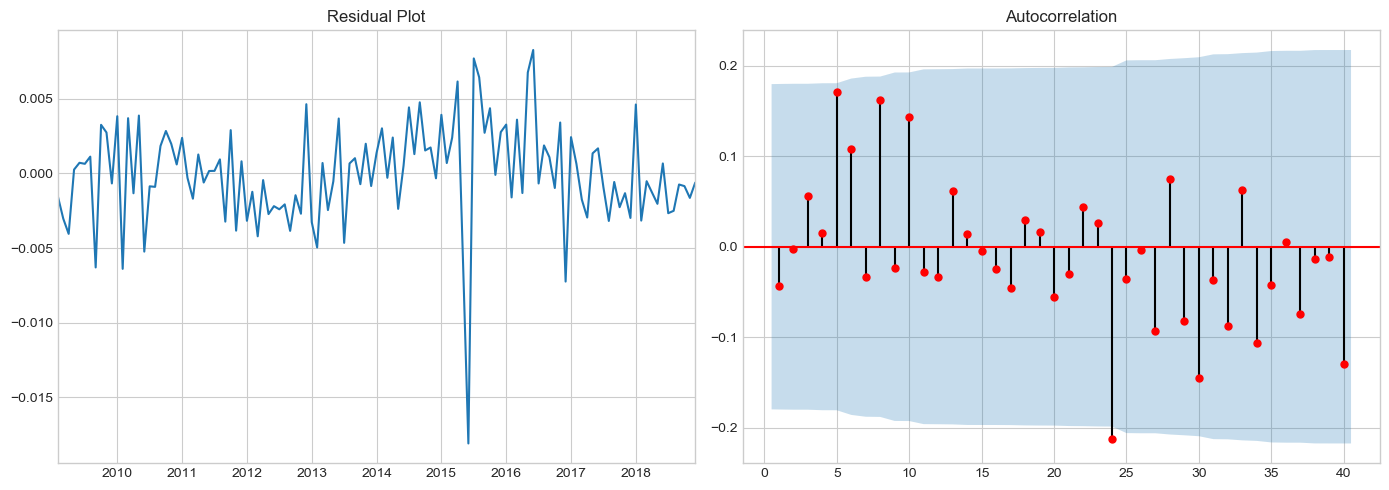

In [305]:
ar = (1,0,0,0,0,0,0,0,0,0,0,0)
ma = (0,0,0,0,0,0,0,0,0,0,0,1)

model = sm.tsa.SARIMAX(log_yearly_train, order = (ar,1,ma))
model_results = model.fit(disp = 0)
resid = model_results.resid

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (14,5))
resid.iloc[1:].plot(ax = ax1)
ax1.set_title("Residual Plot")
ax1.set_xlabel("")


sm.graphics.tsa.plot_acf(resid.iloc[1:], lags = 40, ax = ax2, zero = False, c = "red");
plt.tight_layout()


#model_results.plot_diagnostics(figsize = (14,6), lags = 40)

In [306]:
#model_plot(log_yearly_train.dropna(), 1, 1, 0)
 
#model_plot(log_train, 1, 1, 0)

# model_plot(log_train, 1, 1, 0)

#model_plot(log_yearly_train, 1, 1, 12)

#resid_plot(log_yearly_train, 1, 1, 0)

#resid_plot(log_yearly_train, 1, 1, 12);

#resid_plot(log_yearly_train.diff().dropna(), 1, 0, 0)




# 시계열 모델링

## PMDARIMA 함수를 이용하여 최적 p, q 도출

In [62]:
from pmdarima.arima import auto_arima

stepwise_model = auto_arima(log_yearly_train, start_p=1, start_q=12,
                           max_p=6, max_q=14, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())



Fit ARIMA: order=(1, 1, 12) seasonal_order=(0, 0, 0, 0); AIC=-990.203, BIC=-948.516, Fit time=1.882 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=-953.403, BIC=-947.844, Fit time=0.122 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=-972.790, BIC=-964.453, Fit time=0.084 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=-971.361, BIC=-963.024, Fit time=0.194 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=-955.242, BIC=-952.463, Fit time=0.031 seconds
Fit ARIMA: order=(0, 1, 12) seasonal_order=(0, 0, 0, 0); AIC=-963.778, BIC=-924.870, Fit time=1.011 seconds
Fit ARIMA: order=(1, 1, 11) seasonal_order=(0, 0, 0, 0); AIC=-962.954, BIC=-924.046, Fit time=1.437 seconds
Fit ARIMA: order=(2, 1, 12) seasonal_order=(0, 0, 0, 0); AIC=-989.295, BIC=-944.829, Fit time=1.570 seconds
Near non-invertible roots for order (2, 1, 12)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the u

## 모형 비교 

###  AR (1,1,0)

/Users/macintosh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


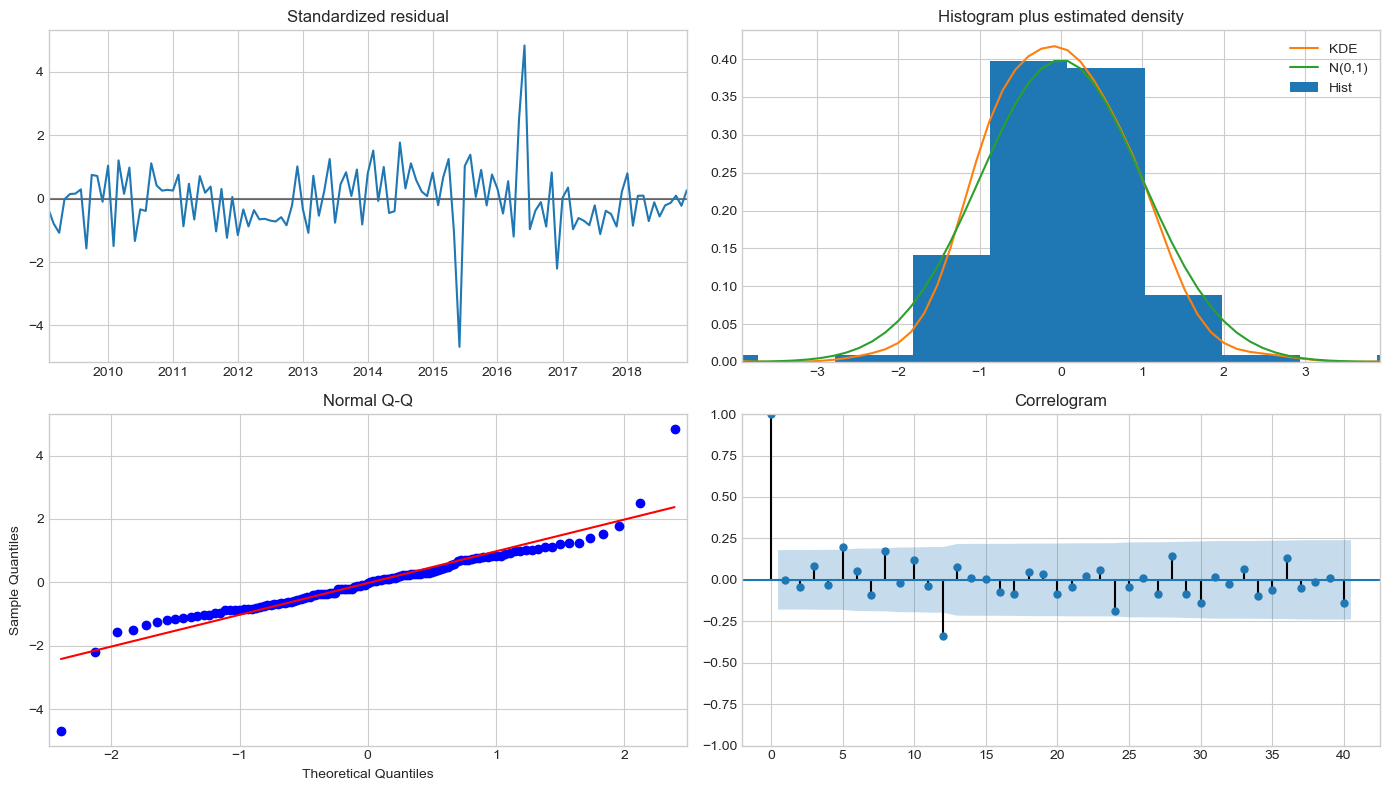

In [325]:
model_results = sm.tsa.SARIMAX(dataset, order = (1,1,0)).fit(disp=0)
#model_result.summary()

model_results.plot_diagnostics(figsize = (14,8), lags = 40)
plt.tight_layout()
#print(model_results.summary())

### ARIMA (1,1,12)

/Users/macintosh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/macintosh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


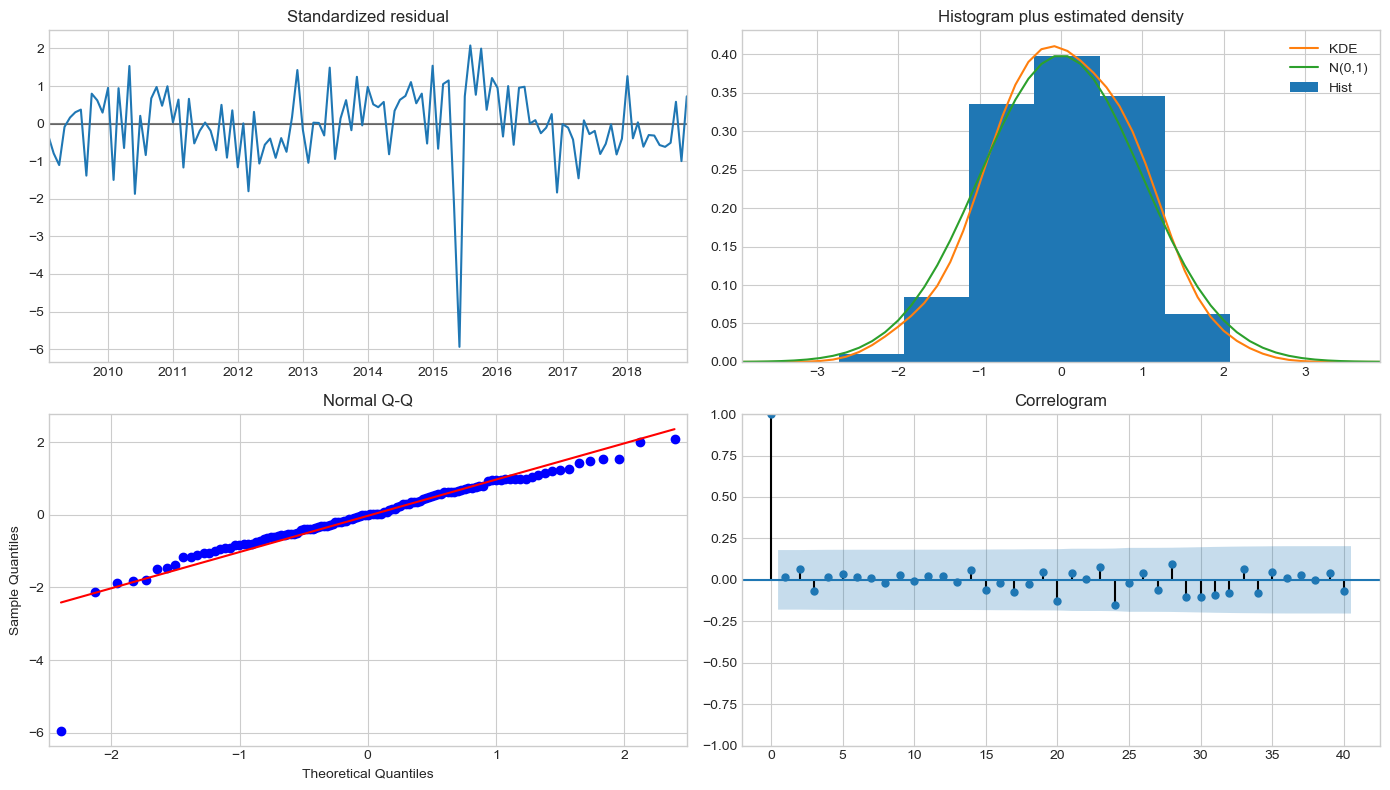

In [326]:
model_results = sm.tsa.SARIMAX(dataset, order = (1,1,12)).fit(disp=0)
#print(model_results.summary())
#model_result.plot_diagnostics()
model_results.plot_diagnostics(figsize = (14,8), lags = 40)
plt.tight_layout()

### ARIMA(12',1,12')

In [ ]:
# Specifying Lags 

dataset = log_yearly_train
ar = (1,0,0,0,0,0,0,0,0,0,0,0)
ma = (0,0,0,0,0,0,0,0,0,0,0,1)


model_results = sm.tsa.SARIMAX(dataset, order = (ar, 1, ma)).fit(disp=0)

#model_result3 = sm.tsa.SARIMAX(log_train, order  = (ar,1,ma),seasonal_order = (1,0,0,12), simple_differencing = True).fit(disp=0)

a = model_result.summary()
model_results.plot_diagnostics(figsize=(20, 12), lags = 40);
plt.tight_layout()
print(a)

# 잔차 분석 (이분산성, 정규성, 자기상관 분석) 

## Ljungbox, Jarque-bera 검정

In [312]:
het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))


Test heteroskedasticity of residuals (breakvar): stat=1.331, p=0.369

Test normality of residuals (jarquebera): stat=180.293, p=0.000

Test serial correlation of residuals (ljungbox): stat=38.719, p=0.528

Durbin-Watson test on residuals: d=2.07
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


## JARQUE-BERA test의 결과 해석

- summary()를 보면 모형의 kurtosis가 높다는 것을 알 수 있다. 
- 이에 따라 residuals의 density plot을 그려보았으며 표준정규분포보다 훨씬 더 뾰족하다는 것을 알 수 있다. 
- 이는 작은 오차의 비율이 비정상적으로 높다는 것이다. 정규분포는 위반이 되나 오차가 커서가 아니라, 작아서 생기는 비정규성이기 때문에 비교적 양호하다고 할 수 있다. 

## 잔차의 분포 시각화

/Users/macintosh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


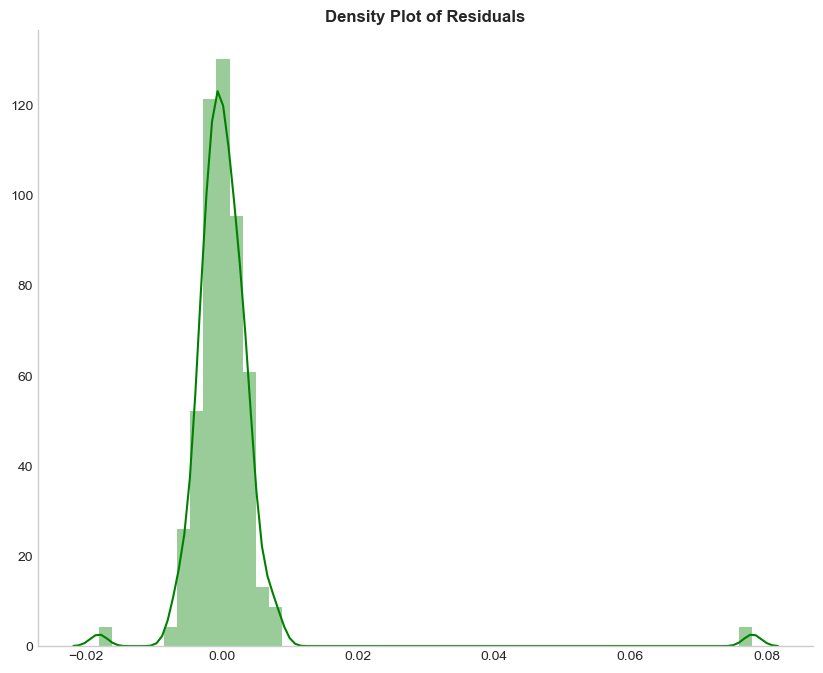

In [319]:
dataset = log_yearly_train
ar = (1,0,0,0,0,0,0,0,0,0,0,0)
ma = (0,0,0,0,0,0,0,0,0,0,0,1)

model_results = sm.tsa.SARIMAX(dataset, order = (ar, 1, ma)).fit(disp=0)

fig = plt.figure(figsize = (10,8))
sns.distplot(model_results.resid, color = "green");
plt.title("Density Plot of Residuals", fontweight = "bold")
plt.grid(False)
sns.despine()



# 예측 및 Performance 비교 

## 최적 시계열 모형 ARIMAX(1, 1, 12') 

In [ ]:
dataset = log_yearly_train
ar = (1,0,0,0,0,0,0,0,0,0,0,0)
ma = (0,0,0,0,0,0,0,0,0,0,0,1)

model_results1 = sm.tsa.SARIMAX(dataset, order = (1, 1,0)).fit(disp=0)
model_results2 = sm.tsa.SARIMAX(dataset, order = (1,1,12)).fit(disp=0)
model_results3 = sm.tsa.SARIMAX(dataset, order = (ar, 1, ma)).fit(disp=0)

print(model_results3.resid)

## FORECASTED VALUE 시각화

Text(0.5, 1.0, 'Non-Inverted In Sample and Out Sample Prediction')

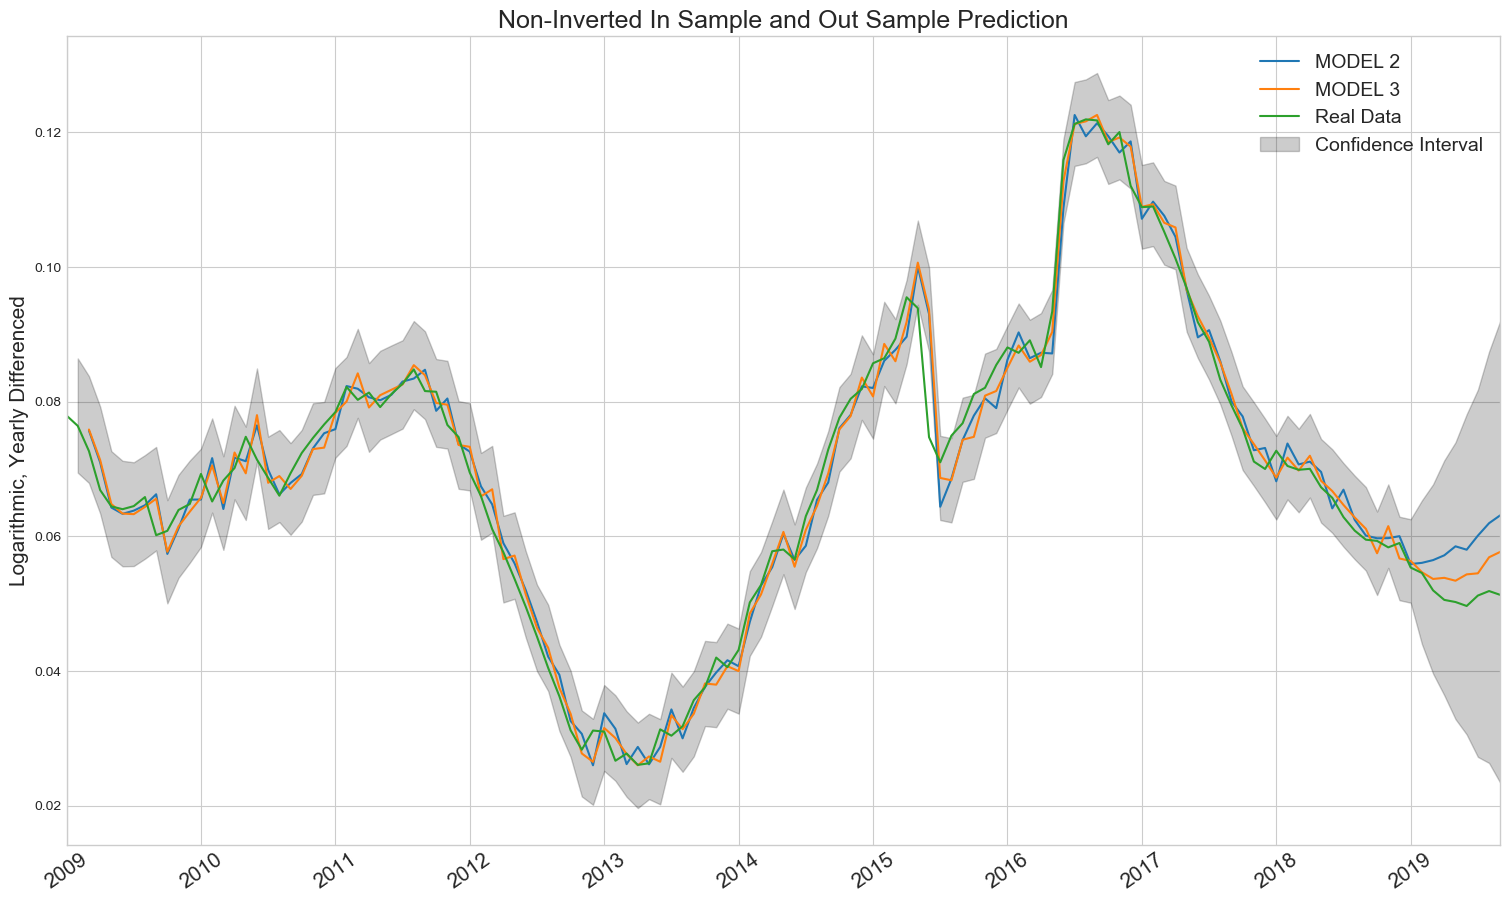

In [354]:
start_index = '2009-02-01'
end_index = '2019-09-01'

# MODEL 1 : AR(1)
# MODEL 2: ARIMA(1,1,12)
# MODEL 3: ARIMA(1,1,12')


#forecast = model_result1.predict(start=start_index, end=end_index)
#forecast2 = model_result2.predict(start=start_index, end=end_index)
#forecast3 = model_result3.predict(start=start_index, end=end_index)


fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

pred1 = model_result1.get_prediction(start=start_index,end=end_index)
pred_mean1 = pred.predicted_mean
pred_ci1 = pred2.conf_int(alpha=0.05)

pred2 = model_result2.get_prediction(start=start_index,end=end_index)
pred_mean2 = pred2.predicted_mean

pred3 = model_result3.get_prediction(start=start_index,end=end_index)
pred_mean3 = pred3.predicted_mean


pred_mean1[1:].plot(label = "MODEL 2")
pred_mean2[1:].plot(label = "MODEL 3")
#pred_mean3[1:].plot(label = "(MODEL 3)")
log_yearly_test.plot(label = "Real Data")
plt.fill_between(pred_ci1.index,
                 pred_ci1.iloc[:, 0],
                 pred_ci1.iloc[:, 1], color='k', alpha=.2, label = "Confidence Interval")

plt.legend(fontsize = 14)
plt.xticks(fontsize = 15, rotation = 35)
plt.xlabel("");
plt.ylabel("Logarithmic, Yearly Differenced", fontsize = 15)
plt.title("Non-Inverted In Sample and Out Sample Prediction", fontsize = 18)



In [335]:
model_results = sm.tsa.SARIMAX(log_yearly_train, order  = (1,1,12), trend = 'c').fit(disp=0)
model_results.get_prediction(start=start_index,end=end_index)

/Users/macintosh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/macintosh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## 차분, 로그 변환 Inversion에 필요한 inverse_diff 정의 

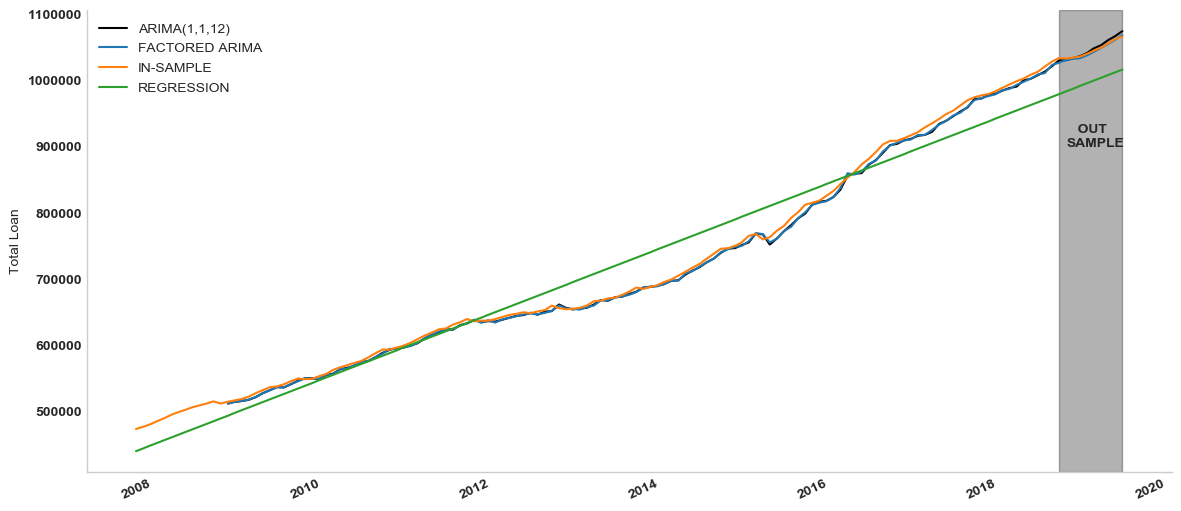

In [362]:
def inverse_diff(dataset, old_dataset, interval = 1, log = False):
    new = dataset.copy(deep=True)
    for i in range(len(dataset)):
        new[i] = dataset[i]+old_dataset[i]
    
    if log: 
        return np.exp(new)
    else: 
        return new
        
original = inverse_diff(log_yearly_train, log_train, 12, True)
predicted1 = inverse_diff(pred_mean1, log_train, 12, True)
predicted2 = inverse_diff(pred_mean2, log_train, 12, True)
linear_predictions = model.predict(new_X)

fig = plt.figure(figsize = (14,6))
plt.plot(predicted1, label = "ARIMA(1,1,12)", c = "black")
plt.plot(predicted2, label = "FACTORED ARIMA")


plt.plot(data["Total Loan"], label = "IN-SAMPLE")
plt.plot(linear_predictions, label = "REGRESSION")

plt.legend()
plt.xticks(fontweight = "bold", rotation = 25)
plt.yticks(fontweight = "bold")  
sns.despine()
plt.ylabel("Total Loan")
plt.axvspan("2018-12-01","2019-09-01" ,alpha=0.3, color='black')
plt.text("2019-01-01", 900000, "   OUT   \nSAMPLE", fontweight = "bold");
plt.grid()



## Out-Sample Zoom-In

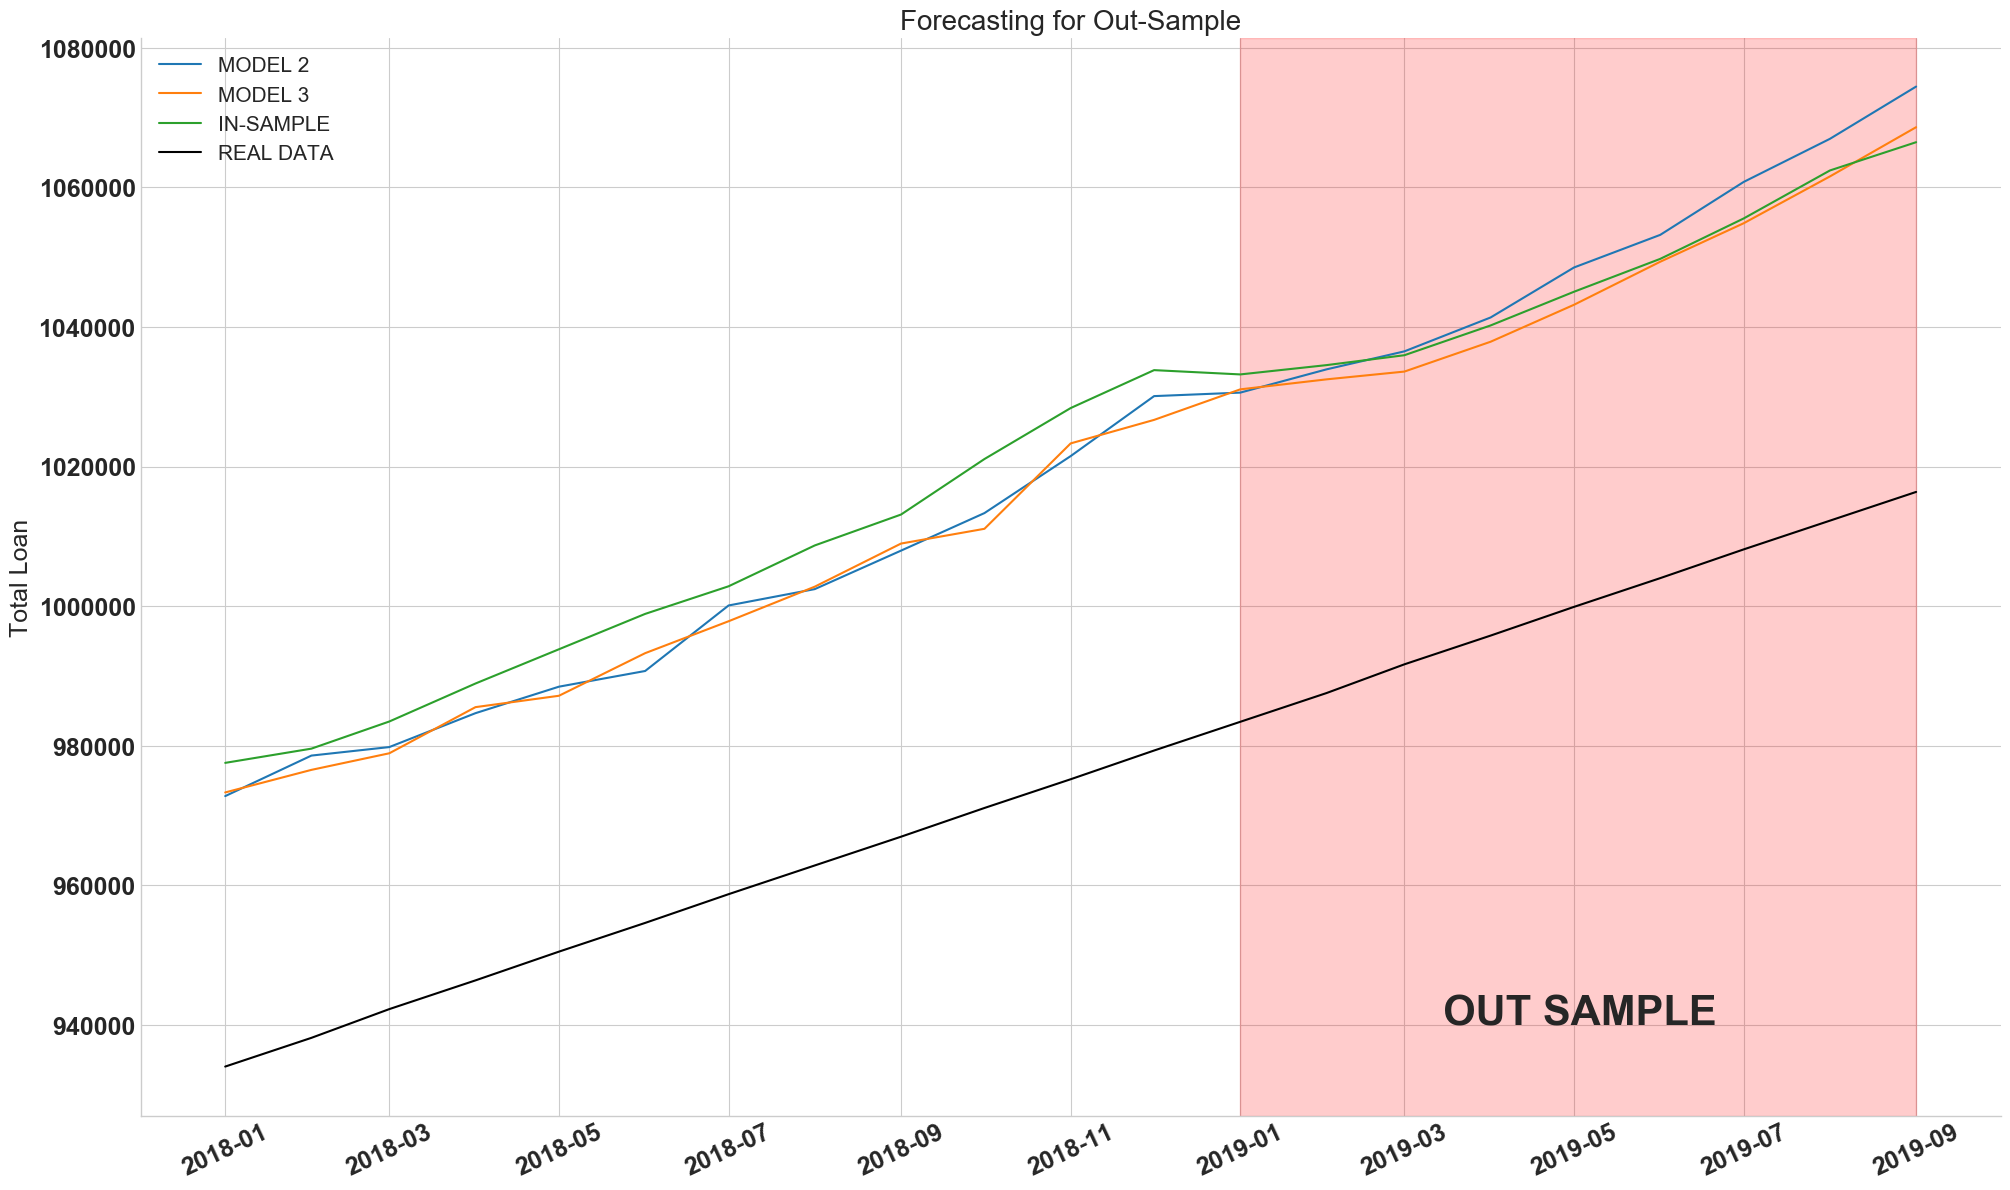

In [385]:
fig = plt.figure()
fig.set_size_inches(24, 14)

plt.plot(predicted1.loc["2018-01-01":], label = "MODEL 2")
plt.plot(predicted2.loc["2018-01-01":], label = "MODEL 3")


plt.plot(data.loc["2018-01-01":,"Total Loan"], label = "IN-SAMPLE")
plt.plot(linear_predictions.loc["2018-01-01":], label = "REAL DATA", c = "black")

plt.title("Forecasting for Out-Sample", fontsize = 20)
plt.legend(fontsize = 15)
plt.xticks(fontweight = "bold", rotation = 25, fontsize = 18)
plt.yticks(fontweight = "bold", fontsize = 18)  
sns.despine()
plt.ylabel("Total Loan", fontsize = 18)
plt.axvspan("2019-01-01","2019-09-01" ,alpha=0.2, color='red')
plt.text("2019-02-01", 940000, "          OUT SAMPLE", fontweight = "bold", fontsize = 30);

# 평가 (Evaluation)

## RMSE, MAPE, MASE 도출 함수 정의

In [134]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [135]:
original = data["Total Loan"]
#arima_pred = predicted
linear_pred = linear_predictions



rmse = get_rmse(original.loc["2019-01-01":], predicted1.loc["2019-01-01":])
print("RMSE: ", rmse)

mape = get_mape(original.loc["2019-01-01":], predicted1.loc["2019-01-01":])
print("MAPE: ", mape)

mase = get_mase(original.loc["2019-01-01":], predicted1.loc["2019-01-01":])
print("MASE: ", mase)

rmse = get_rmse(original.loc["2019-01-01":], predicted2.loc["2019-01-01":])
print("RMSE: ", rmse)

mape = get_mape(original.loc["2019-01-01":], predicted2.loc["2019-01-01":])
print("MAPE: ", mape)

mase = get_mase(original.loc["2019-01-01":], predicted2.loc["2019-01-01":])
print("MASE: ", mase)


rmse = get_rmse(original.loc["2019-01-01":], linear_pred["2019-01-01":])
print("RMSE: ", rmse)

mape = get_mape(original.loc["2019-01-01":], linear_pred["2019-01-01":])
print("MAPE: ", mape)

mase = get_mase(original.loc["2019-01-01":], linear_pred["2019-01-01":])
print("MASE: ", mase)


original


RMSE:  4001.6588246521133
MAPE:  0.3115419576026306
MASE:  0.9748303367146254
RMSE:  1799.6649734137593
MAPE:  0.1577289179098045
MASE:  1.0387035438957224
RMSE:  47170.92132291351
MAPE:  4.499373316271114
MASE:  1.0070809319029113


Date
2008-01-01     473606.9
2008-02-01     476919.4
2008-03-01     480414.7
2008-04-01     485302.9
2008-05-01     489620.6
                ...    
2019-05-01    1045049.6
2019-06-01    1049758.6
2019-07-01    1055549.3
2019-08-01    1062421.9
2019-09-01    1066472.0
Name: Total Loan, Length: 141, dtype: float64

# ADDITIONAL: 전세가격을 이용한 외생변수 도입 (ARIMAX) 

- Performance가 향상되지 않았다. 복잡도만 증가함.

In [69]:
loans = pd.read_excel( " 전세가격.xlsx", skiprows = 10)
loans.drop(["Unnamed: 1","Unnamed: 2","Unnamed: 3"], axis = 1, inplace = True)
loans = loans.T.iloc[1:, 3]
loans.columns = "Seoul"
loans.index = pd.to_datetime(loans.index.str.replace("년", "").str.replace("월", ""))
loans = loans.astype(int)

loans_train = loans.loc["2008-01-01":"2018-12-01"]
loans_test = loans.loc["2019-01-01":]

loans_yearly_train = pd.DataFrame(differencing(np.log(loans_train), 12))
